In [1]:
import pandas as pd 
import numpy as np
from sklearn.cluster import DBSCAN
import geopandas as gpd
import datetime as dt
import copy
import matplotlib.pyplot as plt

In [2]:
def add_noise(cell):
    """
    This function add noise to the input variable
    
    input: a number--fload or integer
    output: a noisy number
    """
    cell = cell + 0.005*np.random.randn()
    return cell

In [3]:
def dbscan_(epsilon_m, min_samples, current_ID):
    eps = epsilon_m * 0.000009
    data = current_ID.copy()
    #data.loc[:,'clusterIndex'] = pd.Series(
     #                                   np.zeros(
      #                                      len(data.index)), 
       #                                         index=data.index)
    
    clustering = DBSCAN(
        eps = eps, min_samples = min_samples).fit(data[['Long','Lat']])
    
    data.loc[:, 'clusterIndex'] = clustering.labels_
    return data

In [4]:
# if data frame became large u have to change block size
raw_data = pd.read_csv(
    '/home/saeedrmd/Documents/Work/MobileData/Data/Data3000fix.csv'
    , parse_dates=[['Date', 'Time']])

# Reading Tehran Shapefile
tehran_shp = gpd.read_file('/home/saeedrmd/Documents/Work/MobileData/TehranGeorefed/Tehran.shp')

In [5]:
# Adding noise
# raw_data['noisy_lat'] = raw_data['Lat'].apply(add_noise)
# raw_data['noisy_long'] = raw_data['Long'].apply(add_noise)

In [6]:
raw_data.sort_values(by=['ID', 'Date_Time'], inplace=True)
raw_data.reset_index(inplace = True, drop = True)

In [7]:
raw_data.head()

Date_Time     ID     Lat    Long
0 2019-07-30 06:53:08  10007  35.823  51.264
1 2019-07-30 06:53:08  10007  35.823  51.264
2 2019-07-30 06:55:42  10007  35.823  51.264
3 2019-07-30 06:55:43  10007  35.823  51.264
4 2019-07-30 06:58:44  10007  35.823  51.264

In [66]:
raw_data_groupby = raw_data.groupby(by=['ID'])
counter = 0
clustered_data_by_Id = {}

for ID in raw_data.ID.unique():
    counter += 1
    current_ID = raw_data_groupby.get_group(ID)

    
    current_Id_clustered = dbscan_(1000, 7, current_ID)
    clustered_data_by_Id['{}'.format(ID)] =  current_Id_clustered
    
    
    if counter == 200: break
        
    

/home/saeedrmd/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


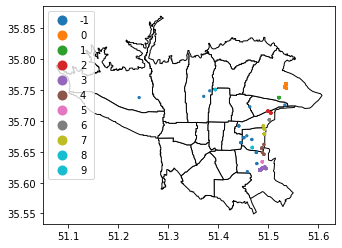

In [67]:
# Creating Person shapefile
current_ID_Points = gpd.GeoDataFrame(
        current_Id_clustered, geometry = gpd.points_from_xy(
                                            current_Id_clustered.Long, 
                                                current_Id_clustered.Lat),  
                                                    crs={'init': 'epsg:4326'})

base = tehran_shp.plot(color='white', edgecolor='black')
current_ID_Points.plot(ax=base, marker='o', column='clusterIndex', markersize=5, categorical=True, legend = True);

/home/saeedrmd/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


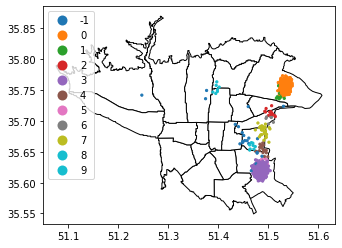

In [68]:
# Creating Noisy Points Shapefile
current_Id_clustered['noisy_lat'] = current_Id_clustered['Lat'].apply(add_noise)
current_Id_clustered['noisy_long'] = current_Id_clustered['Long'].apply(add_noise)

current_Id_clustered_Points = gpd.GeoDataFrame(
    current_Id_clustered, geometry = gpd.points_from_xy(
        current_Id_clustered.noisy_long, current_Id_clustered.noisy_lat),  crs={'init': 'epsg:4326'})

base = tehran_shp.plot(color='white', edgecolor='black')
current_Id_clustered_Points.plot(ax=base, marker='o', column='clusterIndex', markersize=5, categorical=True, legend = True);

In [69]:
current_Id_clustered.groupby(['clusterIndex']).agg(['count'])

Date_Time    ID   Lat  Long geometry noisy_lat noisy_long
                 count count count count    count     count      count
clusterIndex                                                          
-1                  23    23    23    23       23        23         23
 0                 761   761   761   761      761       761        761
 1                  13    13    13    13       13        13         13
 2                  17    17    17    17       17        17         17
 3                2193  2193  2193  2193     2193      2193       2193
 4                  17    17    17    17       17        17         17
 5                   8     8     8     8        8         8          8
 6                   7     7     7     7        7         7          7
 7                  30    30    30    30       30        30         30
 8                   8     8     8     8        8         8          8
 9                   7     7     7     7        7         7          7

# Ploting the cluster time histogram 

In [72]:
# Defining the weekdays in order to seperate workdays and weekdays
current_Id_clustered['weekday'] = current_Id_clustered[['Date_Time']].apply(lambda x: dt.datetime.strftime(x['Date_Time'], '%A'), axis=1)

# Defining the cluster number for which we want to plot the histogram
desired_cluster = copy.copy(current_Id_clustered[current_Id_clustered['clusterIndex'] == 3])

# Filtering Workdays
desired_cluster_workdays = copy.copy(desired_cluster[(desired_cluster['weekday'] != 'Friday')
                                                     & (desired_cluster['weekday'] != 'Thursday')])
# Filtering Weekends
desired_cluster_weekends = copy.copy(desired_cluster[(desired_cluster['weekday'] == 'Friday')
                                                     | (desired_cluster['weekday'] == 'Thursday')])

array([[<AxesSubplot:title={'center':'hour'}>]], dtype=object)

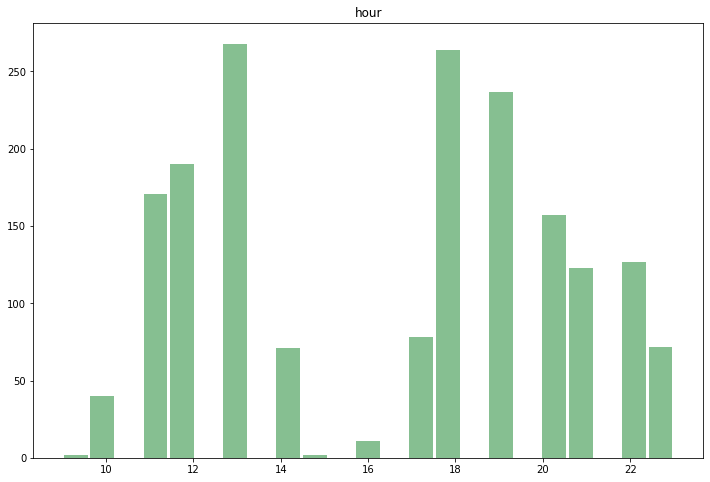

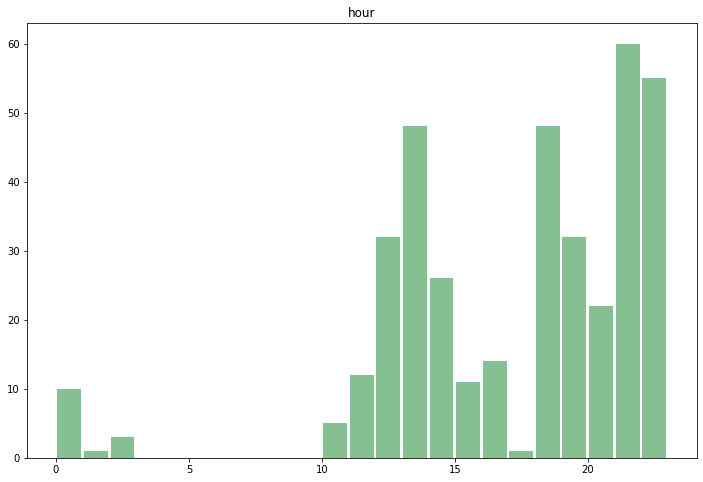

In [73]:
# Defining the hour of connection
desired_cluster_workdays.loc[:, 'hour'] = desired_cluster_workdays.loc[:,'Date_Time'].dt.hour

# Defining the hour of connection
desired_cluster_weekends.loc[:, 'hour'] = desired_cluster_weekends.loc[:,'Date_Time'].dt.hour

# Ploting the histogram
desired_cluster_workdays.hist(column='hour', bins=23, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)

desired_cluster_weekends.hist(column='hour', bins=23, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)
# Method 2: plt.hist(desired_cluster['hour'], bins = 24)

In [ ]:
# Creating Person shapefile
current_ID_Points = gpd.GeoDataFrame(
        current_Id_clustered, geometry = gpd.points_from_xy(
                                            current_Id_clustered.Long, 
                                                current_Id_clustered.Lat),  
                                                    crs={'init': 'epsg:4326'})

base = tehran_shp.plot(color='white', edgecolor='black')
current_ID_Points.plot(ax=base, marker='o', column='clusterIndex', markersize=5, categorical=True, legend = True);

In [ ]:
# Creating Noisy Points Shapefile
current_Id_clustered['noisy_lat'] = current_Id_clustered['Lat'].apply(add_noise)
current_Id_clustered['noisy_long'] = current_Id_clustered['Long'].apply(add_noise)

current_Id_clustered_Points = gpd.GeoDataFrame(
    current_Id_clustered, geometry = gpd.points_from_xy(
        current_Id_clustered.noisy_long, current_Id_clustered.noisy_lat),  crs={'init': 'epsg:4326'})

base = tehran_shp.plot(color='white', edgecolor='black')
current_Id_clustered_Points.plot(ax=base, marker='o', column='clusterIndex', markersize=5, categorical=True, legend = True);

# use DBSCAN to cluster our data

In [ ]:
data_filtered = data_Base[((data_Base.Day == 'Friday') | (data_Base.Day == 'Thursday')) & ((data_Base.StayStart.dt.hour >= 19) | (data_Base.StayStart.dt.hour <= 1)) & (data_Base.Purpose == 'Other')]


In [ ]:
data_Home = data_Base[(data_Base.Purpose == 'Home')][['ID','Lat','Long','manategh','Purpose']]

data_Home=data_Home.drop_duplicates()

In [ ]:
data_filtered = dd.merge(data_filtered,data_Home,on='ID',how='inner')


In [ ]:
data_filtered['Latlong'] = data_filtered[['Lat_x','Long_x']].apply(tuple, axis=1, meta=(None , 'object')) 
data_filtered.head()

# Filter Noises

In [ ]:
data_filtered_Reactivity = data_filtered[data_filtered.Clust_recreational != -1 ]   
data_filtered_Reactivity.head()

# Convert data to pandas DataFrame

In [ ]:
data = data_filtered_Reactivity.compute()


In [ ]:
data.rename(columns ={'Lat_x':'RELat','Long_x':'RELong','manategh_x':'REZones','Lat_y':'Homelat','Long_y':'Homelong','manategh_y':'Homezone'},inplace=True)
data.drop(columns=['Purpose_x','Purpose_y'],inplace=True)
data

Calculate centroids for Clusters

In [ ]:
centroid = data[['RELat','RELong','Clust_recreational']].groupby('Clust_recreational',as_index=False).mean()
centroid.rename(columns={'RELat':'REcentroid','RELong':'REcentroid'},inplace=True)
centroid

we use this to merge centroids with merged dataframe

In [ ]:
data = data.merge(centroid,on='Clust_recreational',how='outer')



# count NoOf Activity and Anntena for each Cluster 
To decide which cluster is Recreational

In [ ]:
l=[]
gp = data.groupby('Clust_recreational')
for i in data.Clust_recreational.unique():
    Total_num = gp.get_group(i)['Latlong'].shape[0]
    NoofuniqueAtenna = gp.get_group(i).Latlong.unique().shape[0]
    l.append([i,Total_num,NoofuniqueAtenna])


clustdetail = pd.DataFrame(l,columns=['Clust','Total Activity','No of Anntena'])

In [ ]:
clustdetail

Then u have to decide which cluster no u need by two factor (Total Activity,No of Anntena)


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
clustdetail.sort_values('Total Activity',ascending=False,inplace=True)
clustdetail.reset_index(inplace = True)
clustdetail.head()

This is for decision making 

In [ ]:
plt.figure(figsize=(17,17))
plt.plot(clustdetail.index,clustdetail['Total Activity'])

collect clusters to use them as recreational clusters

In [ ]:
ClusterCollection = clustdetail['Clust'].loc[:5].to_list()

In [ ]:
Collected = data[data.Clust_recreational.isin(ClusterCollection)]
Collected.head()

# Use pivot table to count transitions between users home and recreational clusters

In [ ]:
pd.pivot_table(Collected,aggfunc=(lambda x: x.count()),index=['Homezone'],columns=['Clust_recreational'],values=['ID'])

In [ ]:
#r[(r.Clust_recreational==28) & (r.Homezone==1)]     #This is for checking

# Spatial join for Recrational Activity

In [ ]:
#data = data.repartition(partition_size='5MB')

In [ ]:
df = data_filtered[['ID','Lat_x','Long_x','Clust_recreational']]
df.head()

In [ ]:
def spj(df):
    
    shp1 = gpd.read_file('E:tehrn.shp') #send this for mr Rahmani
    shp = shp1.to_crs({'init': 'epsg:4326'})
    geodf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(x=df.Long_x, y=df.Lat_x), crs={'init': 'epsg:4326'})
    joined_data =gpd.sjoin(geodf, shp, how='left',op='within')
    
    
    return joined_data
    

In [ ]:
out = df.map_partitions(spj)

data_Base.to_csv('E:outreJoined.csv')